In [1]:
# imports
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import dense_to_sparse
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import torch_geometric
import networkx as nx
from torch_geometric.nn import global_mean_pool
plt.style.use("dark_paper")
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color,cmap="Dark2")
    return fig,ax
def plot_graph(h, color, epoch=None, loss=None):
    fig,ax = plt.subplots(1,1,figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color,edge_color="w", cmap="Set2")
    return fig,ax
from torch_geometric.utils import to_dense_adj

In [2]:
def getDR(tensor):
    phi = tensor[:,-3].repeat_interleave(len(tensor)).view(len(tensor),-1)
    phi -= tensor[:,-3]
    eta = tensor[:,-2].repeat_interleave(len(tensor)).view(len(tensor),-1)
    eta -= tensor[:,-2]
    return torch.sqrt(eta**2+phi**2)

In [3]:
def process(data): 
    x=data.loc[:,["E","px","py","pz","eta","phi","pT"]].to_numpy()
    x=torch.from_numpy(x).float()
    try:
        y=data.loc[:,["mask"]].to_numpy()
    except KeyError:
        y=np.zeros((len(x),1))
    #edge_index=dense_to_sparse(torch.ones(x.shape[0],x.shape[0]).fill_diagonal_(0))[0]#complete
    #edge_index=dense_to_sparse(torch.eye(x.shape[0]))[0]#self only
    #edge_index=dense_to_sparse(torch.ones(x.shape[0],x.shape[0]))[0]#complete graph
    distances = getDR(x)
    edge_index=torch_geometric.nn.radius_graph(distances,r=1)#GCNConv adds self loops
    w = 1/(1+distances[edge_index[0],edge_index[1]])
    data = Data(x=x,
        y=torch.from_numpy(y).float(),
        edge_index=edge_index, 
        edge_weight = w
        ) 
    data.z = (data.y==1).any().float().view(1,1)
    return data

In [4]:
# train_set = [process(pd.read_hdf("data/W/evts.h5", key=f"evt{i}")) for i in range(1,2000)] +\
#             [process(pd.read_hdf("data/QCD/evts_qcd.h5", key=f"evt{i}")) for i in range(1,2000)]
# val_set = [process(pd.read_hdf("data/W/evts.h5", key=f"evt{i}")) for i in range(2000,2201)]+\
#                      [process(pd.read_hdf("data/QCD/evts_qcd.h5", key=f"evt{i}")) for i in range(2000,2201)]
train_set = [process(pd.read_hdf("data/W/full_evts_300pT.h5", key=f"evt{i}")) for i in range(1,150)]
val_set = [process(pd.read_hdf("data/W/full_evts_300pT.h5", key=f"evt{i}")) for i in range(150,300)]

In [5]:
train_loader = DataLoader(train_set, batch_size=1,shuffle=False)
val_loader = DataLoader(val_set, batch_size=1,shuffle=False)

In [6]:
data = train_set[1]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(edge_index=[2, 508], edge_weight=[508], x=[303, 7], y=[303, 1], z=[1, 1])
Number of nodes: 303
Number of edges: 508
Average node degree: 1.68
Contains isolated nodes: True
Contains self-loops: False
Is undirected: True


In [7]:
events = [pd.read_hdf("data/W/full_evts_300pT.h5", key=f"evt{i}") for i in range(1,5)]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


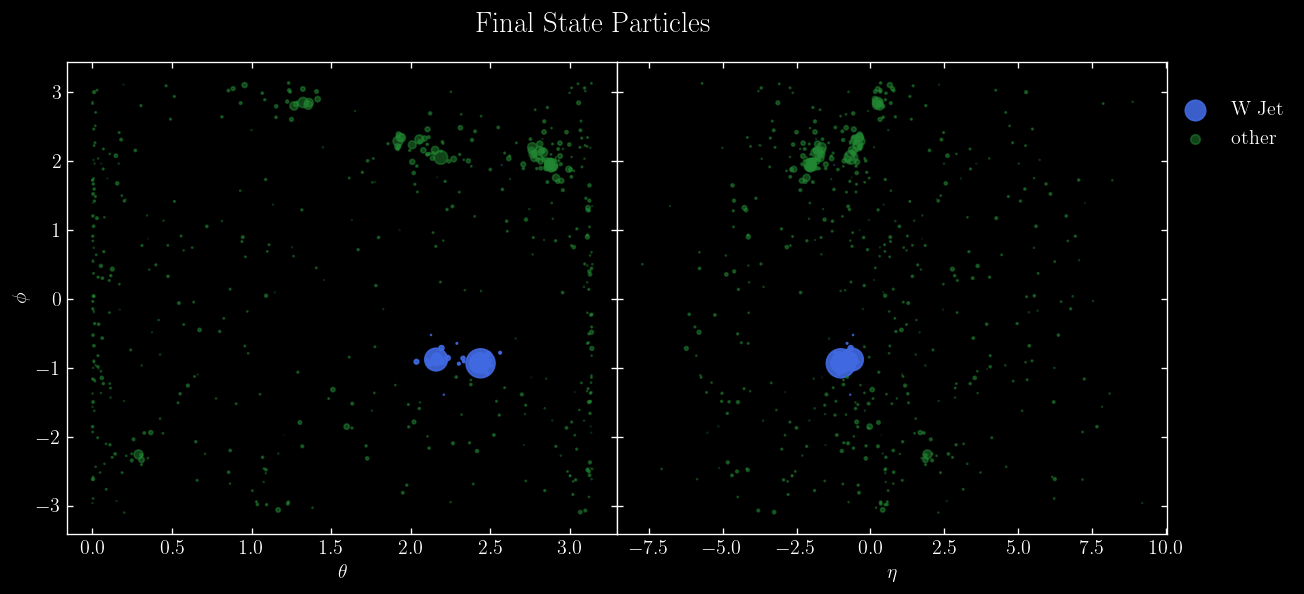

In [8]:
# Plot
i = 0
from_parton = events[i][events[i]["mask"]==1]
notfrom_parton = events[i][events[i]["mask"]==0]

s=300
fig, (ax,ax1) = plt.subplots(1, 2, dpi=120,figsize=(10,5),sharey=True)
ax.scatter(from_parton.theta, from_parton.phi, label="W Jet",s=s*from_parton.pT/events[i].pT.max(),alpha=.9)
ax.scatter(notfrom_parton.theta.values[1:], notfrom_parton.phi.values[1:], 
           label="other",s=s*notfrom_parton.pT[1:]/events[i].pT.max(),alpha=.5)


ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\phi$")

ax1.scatter(from_parton.eta, from_parton.phi, label="W Jet",s=s*from_parton.pT/events[i].pT.max(),
            alpha=.9)
ax1.scatter(notfrom_parton.eta.values[1:], notfrom_parton.phi.values[1:], label="other",
            s=s*notfrom_parton.pT[1:]/events[i].pT.max(),alpha=.5)
ax1.set_xlabel(r"$\eta$")

fig.suptitle("Final State Particles")
fig.tight_layout(w_pad=0)
plt.legend(loc=(1, .8))
plt.show()

In [9]:
from torch.nn import functional as F
class GCN_static(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        #GraphConv vs GCNConv
        self.conv1 = torch_geometric.nn.GraphConv(2, hidden_channels)
        self.conv2 = torch_geometric.nn.GraphConv(hidden_channels, hidden_channels)
        self.conv3 = torch_geometric.nn.GraphConv(hidden_channels, hidden_channels)
        self.conv4 = torch_geometric.nn.GraphConv(hidden_channels, hidden_channels)
        self.conv5 = torch_geometric.nn.GraphConv(hidden_channels, 1)
        self.batchnorm = torch.nn.BatchNorm1d(hidden_channels)
    def forward(self, x, edge_index,edge_weight=None,batch=None):
        x = self.conv1(x, edge_index,edge_weight=edge_weight).relu()
        x = self.batchnorm(x)
        x = self.conv2(x, edge_index,edge_weight=edge_weight).relu()
        x = self.conv3(x, edge_index,edge_weight=edge_weight).relu()
        x = self.conv4(x, edge_index,edge_weight=edge_weight).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index,edge_weight=edge_weight)
        return x

# Complete graph 

In [10]:
targets = torch.from_numpy(np.concatenate([data.y.tolist() for data in train_set]))
ones_weight = targets.sum().item()/len(targets)
weight = 1/torch.tensor([1-ones_weight,ones_weight])/2

In [11]:
def get_weights(targets):
    weight_ = weight[targets.data.view(-1).long()].view_as(targets)
    weight_ = weight_.to(targets.device)
    return weight_
    
def train(data,weighted=True):
    gcn.train()
    weight_ = get_weights(data.y)
    segmentation = gcn(data.x[:,[-3,-2]],data.edge_index,data.edge_weight,None)
                       #,data.edge_weight,data.batch)
    #segmentation = gcn(data.x[:,[0,1,2,3]],data.edge_index,data.batch)
    segmentation = torch.sigmoid(segmentation)
    loss = criterion(segmentation, data.y)
    if weighted:
        loss = (loss*weight_).mean()
    else:
        loss = loss.mean() #mean over graph and batch
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

def val(data,weighted=True):
    gcn.eval()
    weight_ = get_weights(data.y)
    with torch.no_grad():
        segmentation = gcn(data.x[:,[-3,-2]],data.edge_index,data.edge_weight,None)#[data.train_mask]
        segmentation = torch.sigmoid(segmentation)
        loss = criterion(segmentation,data.y)
        if weighted:
            loss = (loss*weight_).mean()
        else:
            loss = loss.mean()
    return loss.item()

In [12]:
#single graph
device = 'cuda:0'
gcn = GCN_static(128)
gcn.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(gcn.parameters(),weight_decay=5e-4,lr=5e-3)
epochs = 500
data = next(iter(train_loader))
data = data.to(device)
for epoch in range(1,epochs):
    loss = train(data)
    if epoch%50==1:
        print(f"Epoch {epoch:^3d}/{epochs} | Loss segmentation {loss:^4.4f}")#| Loss class {loss[1]:^4.4f}")

Epoch  1 /500 | Loss segmentation 0.1990
Epoch 51 /500 | Loss segmentation 0.0095
Epoch 101/500 | Loss segmentation 0.0052
Epoch 151/500 | Loss segmentation 0.0047
Epoch 201/500 | Loss segmentation 0.0046
Epoch 251/500 | Loss segmentation 0.0048
Epoch 301/500 | Loss segmentation 0.0048
Epoch 351/500 | Loss segmentation 0.0046
Epoch 401/500 | Loss segmentation 0.0043
Epoch 451/500 | Loss segmentation 0.0043


In [14]:
pred = (torch.sigmoid(gcn(data.x[:,[-3,-2]].to(device),data.edge_index.to(device), None,
                          torch.zeros(len(data.x)).to(device).long())).detach().cpu().flatten().numpy()>.5).astype(int)
target = data.y.flatten().cpu().numpy()
print(classification_report(target,pred))
print(confusion_matrix(target,pred,))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       530
         1.0       1.00      0.94      0.97        34

    accuracy                           1.00       564
   macro avg       1.00      0.97      0.98       564
weighted avg       1.00      1.00      1.00       564

[[530   0]
 [  2  32]]


In [15]:
#all graphs
device = 'cuda:0'
gcn = GCN_static(256)
gcn.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(gcn.parameters(),weight_decay=5e-4,lr=1e-5)
epochs = 200
losses_train = list()
losses_val = list()
for epoch in range(1,epochs):
    loss_train = 0
    for dat in train_loader:
        loss = train(dat.to(device))
        losses_train.append(loss)
        loss_train +=loss
    loss_train/=len(train_loader)
    if epoch%2==0:
        loss_val = 0
        for dat in val_loader:
            loss = val(dat.to(device))
            losses_val.append(loss)
            loss_val += loss
        loss_val/=len(val_loader)
        #print(f"Epoch {epoch:^3d}/{epochs} | Loss train {loss:^4.4f}")
        print(f"Epoch {epoch:^3d}/{epochs} | Loss train {loss_train:^4.4f}| Loss val {loss_val:^4.4f}")

Epoch  2 /200 | Loss train 0.2709| Loss val 0.2513
Epoch  4 /200 | Loss train 0.1887| Loss val 0.1851
Epoch  6 /200 | Loss train 0.1395| Loss val 0.1416
Epoch  8 /200 | Loss train 0.1212| Loss val 0.1261
Epoch 10 /200 | Loss train 0.1132| Loss val 0.1185
Epoch 12 /200 | Loss train 0.1159| Loss val 0.1163
Epoch 14 /200 | Loss train 0.1118| Loss val 0.1123
Epoch 16 /200 | Loss train 0.1098| Loss val 0.1068
Epoch 18 /200 | Loss train 0.1064| Loss val 0.1086
Epoch 20 /200 | Loss train 0.1084| Loss val 0.1086
Epoch 22 /200 | Loss train 0.1040| Loss val 0.1060
Epoch 24 /200 | Loss train 0.1059| Loss val 0.1061
Epoch 26 /200 | Loss train 0.1068| Loss val 0.1070
Epoch 28 /200 | Loss train 0.1036| Loss val 0.1063
Epoch 30 /200 | Loss train 0.0985| Loss val 0.1073
Epoch 32 /200 | Loss train 0.1011| Loss val 0.1067
Epoch 34 /200 | Loss train 0.1000| Loss val 0.1069
Epoch 36 /200 | Loss train 0.1004| Loss val 0.1062
Epoch 38 /200 | Loss train 0.0958| Loss val 0.1051
Epoch 40 /200 | Loss train 0.10

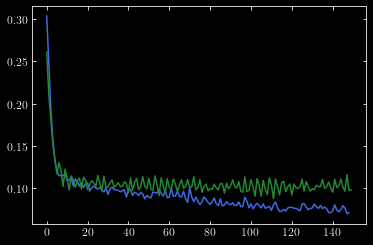

In [16]:
plt.plot(np.reshape(losses_train,(len(train_set),-1)).mean(1))
plt.plot(np.reshape(losses_val,(len(val_set),-1)).mean(1))

### Metrics

In [18]:
pred = []
target = []
gcn.train()
for data in train_loader:
#data = next(iter(train_loader))
    data = data.to(device)
    pred += (torch.sigmoid(gcn(data.x[:,[-3,-2]].to(device),data.edge_index.to(device), 
                              None)).detach().cpu().flatten()>.5).int().tolist()
    target += data.y.flatten().cpu().tolist()
print(classification_report(target,pred))
print(confusion_matrix(target,pred,))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     66478
         1.0       0.69      0.39      0.50      5830

    accuracy                           0.94     72308
   macro avg       0.82      0.69      0.73     72308
weighted avg       0.93      0.94      0.93     72308

[[65481   997]
 [ 3567  2263]]


In [19]:
pred = []
target = []
for data in val_loader:
#data = next(iter(train_loader))
    data = data.to(device)
    pred += (torch.sigmoid(gcn(data.x[:,[-3,-2]].to(device),data.edge_index.to(device), 
                              None)).detach().cpu().flatten()>.5).int().tolist()
    target += data.y.flatten().cpu().tolist()
print(classification_report(target,pred))
print(confusion_matrix(target,pred,))

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     69755
         1.0       0.46      0.22      0.30      5859

    accuracy                           0.92     75614
   macro avg       0.70      0.60      0.63     75614
weighted avg       0.90      0.92      0.91     75614

[[68242  1513]
 [ 4558  1301]]


# Plots

In [1]:
data = val_set[0]
data = data.to(device)
cut = .2
pred = (torch.sigmoid(gcn(data.x[:,[-3,-2]].to(device),data.edge_index.to(device), 
                              None)).detach().cpu().flatten()>cut).int()
target = data.y.flatten().cpu().tolist()
data.to("cpu")
print(classification_report(target,pred.numpy()))
print(confusion_matrix(target,pred.numpy()))

NameError: name 'val_set' is not defined

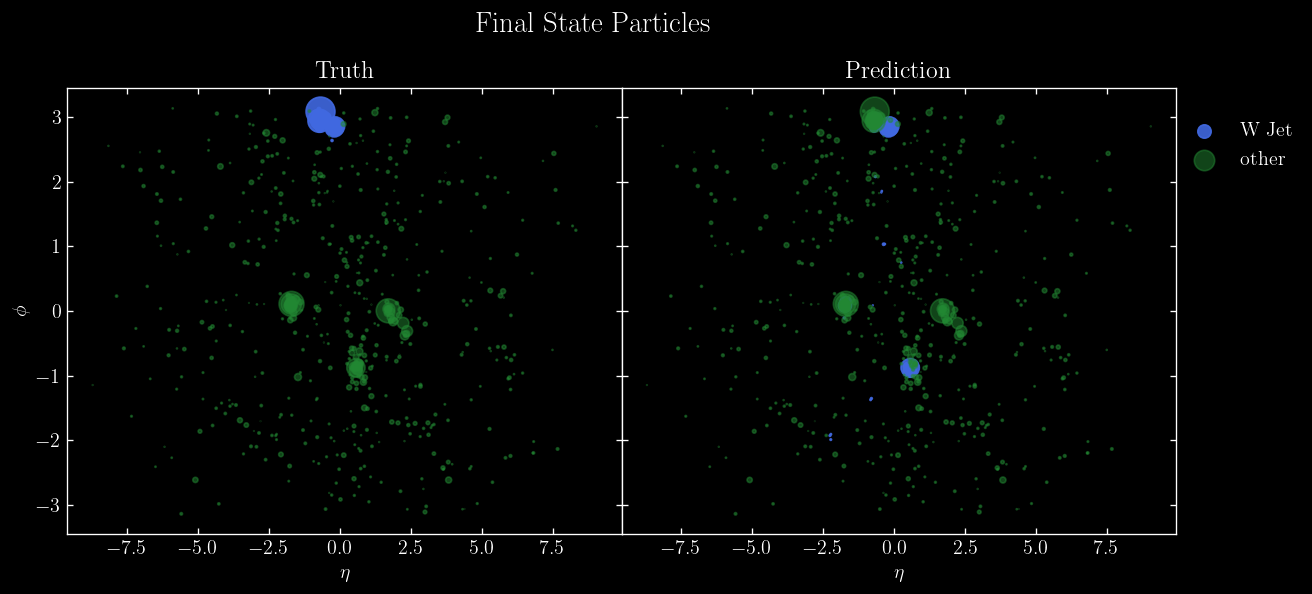

In [32]:
# Plot
from_parton = data.x[pred==1].numpy()
notfrom_parton = data.x[pred==0].numpy()

from_parton_truth = data.x[data.y.flatten()==1].numpy()
notfrom_parton_truth = data.x[data.y.flatten()==0].numpy()

s=300
fig, (ax,ax1) = plt.subplots(1, 2, dpi=120,figsize=(10,5),sharey=True)
ax.scatter(from_parton_truth[:,-3], from_parton_truth[:,-2], label="W Jet",s=s*from_parton_truth[:,-1]/data.x[:,-1].max(),
           alpha=.9)
ax.scatter(notfrom_parton_truth[:,-3], notfrom_parton_truth[:,-2], 
           label="other",s=s*notfrom_parton_truth[:,-1]/data.x[:,-1].max(),
           alpha=.5)


ax.set_xlabel(r"$\eta$")
ax.set_ylabel(r"$\phi$")
ax.set_title("Truth")

ax1.scatter(from_parton[:,-3], from_parton[:,-2], label="W Jet",s=s*from_parton[:,-1]/data.x[:,-1].max(),
            alpha=.9)
ax1.scatter(notfrom_parton[:,-3], notfrom_parton[:,-2], label="other",
            s=s*notfrom_parton[:,-1]/data.x[:,-1].max(),
            alpha=.5)
ax1.set_xlabel(r"$\eta$")
ax1.set_title("Prediction")

fig.suptitle("Final State Particles")
fig.tight_layout(w_pad=0)
plt.legend(loc=(1, .8))
plt.show()